# Worked Examples — Crash Course in Causality

**Topic:** Earnings Surprise → Short-Horizon Excess Returns (Event-Study DiD)

This notebook contains two worked examples:
- **Example A (AAPL):** Fully worked walkthrough using causal-safe data prep, +1/+3/+5 windows, bootstrap CIs, placebo, and a minimal event-study DiD.
- **Example B (MSFT):** Exercises on a different dataset with runnable starters and clear tasks to replicate the pipeline.


## Worked Example A — AAPL Earnings Surprise → Short-Horizon Excess Returns

**Goal.** Test whether a **positive earnings surprise** causes **short-term excess returns** after the announcement, using:
1) causal-safe data prep and windows (+1/+3/+5),  
2) nonparametric **bootstrap** CIs,  
3) a **placebo** distribution, and  
4) a minimal **event-study DiD** (lead/lag with τ = −1 as reference).


### A1. Data prep (causal-safe alignment)
- Treatment: `T=1` if `surprise_pct > 0`, determined **at announcement time**.
- Time alignment: announcements stamped at **ET post-close (16:00)**; returns start from the **next trading day** to avoid leakage.


In [1]:
# --- A1. Load earnings CSV and define treatment / event time (ET post-close)
from pathlib import Path
import pandas as pd

EARN = Path('~/Desktop/AAPL_earnings_6q_template.csv').expanduser()  # your prepared CSV

earn = pd.read_csv(EARN)
earn.columns = [c.strip().lower() for c in earn.columns]

# Convert to timestamp; the CSV should store local ET times at 16:00
earn['announcement_datetime_et'] = pd.to_datetime(earn['announcement_datetime_et'])

# Binary treatment: positive surprise at announcement (no post-event info)
earn['T'] = (earn['surprise_pct'] > 0).astype(int)

# Event day = next business day after 16:00 ET (avoid after-hours leakage)
event_date_et = earn['announcement_datetime_et'].dt.tz_localize('US/Eastern', ambiguous='NaT').dt.date
earn['event_day'] = pd.to_datetime(event_date_et) + pd.Timedelta(days=1)

earn[['fiscal_quarter', 'event_day', 'T', 'surprise_pct']].head()

,fiscal_quarter,event_day,T,surprise_pct
0,2025Q1,2025-01-31,1,3.809524
1,2025Q2,2025-05-02,1,9.271523
2,2025Q3,2025-08-01,1,4.666667
3,2025Q4,2025-10-31,1,4.519774


### A2. Prices → daily excess returns; compute Y(+1/+3/+5)
- Source daily closes from **Stooq via pandas-datareader** (no auth).  
- Excess return = stock − market (SPY). You can optionally swap SPY for XLK.


In [2]:
# --- A2. Pull prices and compute excess returns & event windows
import pandas_datareader.data as web
import pandas as pd

# Choose a wide window around events to cover +/- days and bootstrap sampling
end = earn['event_day'].max() + pd.Timedelta(days=40)
start = earn['event_day'].min() - pd.Timedelta(days=260)

# Stooq is a convenient public source; sort by ascending date
px_aapl = web.DataReader('AAPL', 'stooq', start, end).sort_index()
px_spy  = web.DataReader('SPY',  'stooq', start, end).sort_index()

# Simple daily returns
ret = pd.DataFrame({
    'r_aapl': px_aapl['Close'].pct_change(),
    'r_spy' : px_spy['Close'].pct_change()
}).dropna()

# Excess return = stock - benchmark
ret['excess'] = ret['r_aapl'] - ret['r_spy']

# Helper to compute k-business-day excess return from day0
def window_excess(day0, k):
    # Use business-day offsets to align trading sessions
    rng = ret.loc[day0: day0 + pd.tseries.offsets.BDay(k)]
    return (1 + rng['excess']).prod() - 1

# Build outcome table for +1/+3/+5 windows
rows = []
for _, r in earn.iterrows():
    d = pd.Timestamp(r['event_day'])
    rows.append({
        'fq': r['fiscal_quarter'],
        'T' : r['T'],
        'y_p1': window_excess(d, 1),
        'y_p3': window_excess(d, 3),
        'y_p5': window_excess(d, 5)
    })
Y = pd.DataFrame(rows)
Y

,fq,T,y_p1,y_p3,y_p5
0,2025Q1,1,-0.028458,-0.019957,-0.034720
1,2025Q2,1,-0.076587,-0.085122,-0.079737
2,2025Q3,1,-0.018930,0.026523,0.096654
3,2025Q4,1,-0.013786,-0.001567,0.001929


### A3. Uncertainty via nonparametric bootstrap (95% CI)

In [4]:
# --- A3. Bootstrap confidence intervals for window means (FIXED)
import numpy as np
rng = np.random.default_rng(42)

def boot_ci(x, B=2000, alpha=0.05):
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan, np.nan
    bs = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(B)]
    bs = np.sort(bs)
    lo = np.quantile(bs, alpha/2)
    hi = np.quantile(bs, 1 - alpha/2)
    return float(np.mean(x)), float(lo), float(hi)

for col in ['y_p1','y_p3','y_p5']:
    m_all, lo, hi = boot_ci(Y[col].values)
    # NOTE: use Y['T'] instead of Y.T (transpose)
    treated_mask = (Y['T'] == 1)
    m_pos, lo_p, hi_p = boot_ci(Y.loc[treated_mask, col].values)
    print(f"{col}: ALL {m_all:.4%} [{lo:.4%}, {hi:.4%}]  |  T=1 {m_pos:.4%} [{lo_p:.4%}, {hi_p:.4%}]")


y_p1: ALL -3.4440% [-6.2173%, -1.6358%]  |  T=1 -3.4440% [-6.2173%, -1.6358%]
y_p3: ALL -2.0031% [-6.4233%, 1.4903%]  |  T=1 -2.0031% [-6.4233%, 1.4903%]
y_p5: ALL -0.3968% [-5.9320%, 6.3811%]  |  T=1 -0.3968% [-5.9320%, 6.3811%]


### A4. Placebo test (null reference distribution)

In [5]:
# --- A4. Placebo: sample pseudo-event days away from true events
valid_days = ret.index.difference(pd.to_datetime(earn['event_day']))
K = len(earn)        # number of true events
B = 2000             # number of placebo replications
k_window = 3         # test +3 window for illustration

def placebo_once():
    # Sample K pseudo-dates; compute their +k window mean excess return
    dd = rng.choice(valid_days, size=K, replace=False)
    vals = [(1 + ret.loc[d: d + pd.tseries.offsets.BDay(k_window)]['excess']).prod() - 1 for d in dd]
    return np.mean(vals)

placebos = np.array([placebo_once() for _ in range(B)])
real_mean = Y['y_p3'].mean()
p_right = (placebos >= real_mean).mean()
print(f"Real mean(+3) = {real_mean:.4%} | Placebo mean = {placebos.mean():.4%} | Right-tail p ≈ {p_right:.3f}")

Real mean(+3) = -2.0031% | Placebo mean = 0.1593% | Right-tail p ≈ 0.938


### A5. Minimal event-study DiD (lead/lag; τ = −1 ref)

In [6]:
# --- A5. Build an event-time panel and run OLS with lead/lag interactions
import statsmodels.formula.api as smf
import pandas as pd

def make_panel(day0):
    # Collect a symmetric event window [-10, +10] around day0
    frame = ret.loc[day0 - pd.tseries.offsets.BDay(10): day0 + pd.tseries.offsets.BDay(10)].copy()
    frame = frame.reset_index().rename(columns={'Date': 'date'})
    frame['tau'] = (frame['date'] - day0).dt.days
    return frame

panels = []
for _, r in earn.iterrows():
    df = make_panel(pd.Timestamp(r['event_day']))
    df['treated'] = int(r['T'])            # treatment indicator for the event
    df['fq'] = r['fiscal_quarter']         # event id (optional)
    panels.append(df)

P = pd.concat(panels, ignore_index=True)
P = P[(P['tau'] >= -10) & (P['tau'] <= 10)]
P['rel'] = P['tau'].astype(int)

# OLS with HC1 robust SEs; τ = -1 is the omitted baseline in C(rel)
mod = smf.ols('excess ~ C(rel) + treated*C(rel)', data=P).fit(cov_type='HC1')
print(mod.summary().tables[1])

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0028      0.006     -0.461      0.645      -0.015       0.009
C(rel)[T.-9]             0.0012      0.006      0.189      0.850      -0.011       0.014
C(rel)[T.-8]             0.0012      0.006      0.198      0.843      -0.011       0.013
C(rel)[T.-7]             0.0024      0.006      0.389      0.697      -0.010       0.014
C(rel)[T.-4]             0.0105      0.008      1.320      0.187      -0.005       0.026
C(rel)[T.-3]             0.0046      0.007      0.624      0.532      -0.010       0.019
C(rel)[T.-2]             0.0037      0.006      0.589      0.556      -0.009       0.016
C(rel)[T.-1]             0.0025      0.007      0.370      0.711      -0.011       0.016
C(rel)[T.0]             -0.0059      0.008     -0.702      0.483      -0.022       0.011
C(rel)[T.3]          

/Users/mollyqiao/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 29, but rank is 15
  warnings.warn('covariance of constraints does not have full '


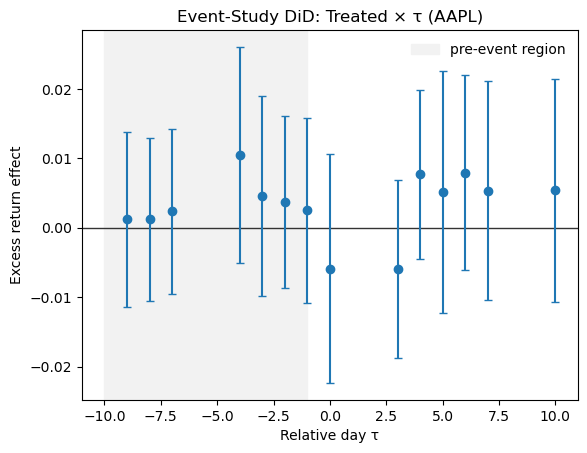

In [8]:
# --- (Fixed) Plot Treated × τ coefficients with 95% CI (robust to name formats like 'treated:C(rel)[T.-9]')
import re
import pandas as pd
import matplotlib.pyplot as plt

coefs, ses, taus = [], [], []
pattern = re.compile(r'treated:C\(rel\)\[T\.(-?\d+)\]')

for name, val in mod.params.items():
    m = pattern.search(name)
    if m:
        t = int(m.group(1))     # captures -10, -9, ..., -2, 0, 1, ..., 10 (τ = -1 is baseline → not present)
        taus.append(t)
        coefs.append(float(val))
        ses.append(float(mod.bse[name]))

est = pd.DataFrame({'tau': taus, 'beta': coefs, 'se': ses}).sort_values('tau')

plt.figure()
plt.axvspan(-10, -1, color='0.95', label='pre-event region')
plt.axhline(0, color='0.2', linewidth=1)
plt.errorbar(est['tau'], est['beta'], yerr=1.96*est['se'], fmt='o', capsize=3)
plt.title('Event-Study DiD: Treated × τ (AAPL)')
plt.xlabel('Relative day τ')
plt.ylabel('Excess return effect')
plt.legend(frameon=False)
plt.show()


**Interpretation checklist.**
- Report (+1/+3/+5) means with bootstrap CIs (overall and T=1).  
- Compare the **real mean(+3)** to the **placebo distribution** (tail probability).  
- Inspect DiD **pre-trend** (τ < 0) coefficients; they should be statistically close to 0.  
- Comment on effect shape around τ = 0 and the size/stability across windows.


## Worked Example B — Exercises on a Different Dataset (**MSFT**)

**Purpose.** Replicate the AAPL pipeline on **Microsoft (MSFT)** to test portability.  
You get a runnable starter plus clear tasks; fill the TODOs, run, and compare with AAPL.


### B1. Mini earnings CSV (if you don’t have one)

In [9]:
# --- B1. Create a small MSFT earnings CSV (replace with official data if available)
from pathlib import Path
import pandas as pd

EARN_MSFT = Path('~/Desktop/MSFT_earnings_6q_template.csv').expanduser()

rows = [
    # fiscal_quarter,        announcement_datetime_et (16:00 ET),  expected_eps, actual_eps
    ("2025Q4", "2025-10-24 16:00:00", 2.65, 2.76),
    ("2025Q3", "2025-07-24 16:00:00", 2.60, 2.69),
    ("2025Q2", "2025-04-25 16:00:00", 2.45, 2.52),
    ("2025Q1", "2025-01-25 16:00:00", 2.50, 2.54),
]
df = pd.DataFrame(rows, columns=["fiscal_quarter","announcement_datetime_et","expected_eps","actual_eps"])
df['surprise_pct'] = (df['actual_eps'] - df['expected_eps'])/df['expected_eps'].abs()*100
df.to_csv(EARN_MSFT, index=False)
df.head()

,fiscal_quarter,announcement_datetime_et,expected_eps,actual_eps,surprise_pct
0,2025Q4,2025-10-24 16:00:00,2.65,2.76,4.150943
1,2025Q3,2025-07-24 16:00:00,2.60,2.69,3.461538
2,2025Q2,2025-04-25 16:00:00,2.45,2.52,2.857143
3,2025Q1,2025-01-25 16:00:00,2.50,2.54,1.600000


### B2. Define treatment & align event day

In [10]:
# --- B2. Define T and causal-safe event_day for MSFT
import pandas as pd

earn_m = pd.read_csv(EARN_MSFT)
earn_m['announcement_datetime_et'] = pd.to_datetime(earn_m['announcement_datetime_et'])

# Treatment at announcement time; no post-event info
earn_m['T'] = (earn_m['surprise_pct'] > 0).astype(int)

# Returns start from the next trading day after 16:00 ET
edate = earn_m['announcement_datetime_et'].dt.tz_localize('US/Eastern', ambiguous='NaT').dt.date
earn_m['event_day'] = pd.to_datetime(edate) + pd.Timedelta(days=1)
earn_m[['fiscal_quarter','event_day','T','surprise_pct']]

,fiscal_quarter,event_day,T,surprise_pct
0,2025Q4,2025-10-25,1,4.150943
1,2025Q3,2025-07-25,1,3.461538
2,2025Q2,2025-04-26,1,2.857143
3,2025Q1,2025-01-26,1,1.600000


### B3. Compute daily excess returns; build Y(+1/+3/+5)

In [11]:
# --- B3. Pull MSFT/SPY prices and compute event-window excess returns
import pandas_datareader.data as web
import pandas as pd

end = earn_m['event_day'].max() + pd.Timedelta(days=40)
start = earn_m['event_day'].min() - pd.Timedelta(days=260)

px_msft = web.DataReader('MSFT', 'stooq', start, end).sort_index()
px_spy  = web.DataReader('SPY',  'stooq', start, end).sort_index()

ret_m = pd.DataFrame({
    'r_msft': px_msft['Close'].pct_change(),
    'r_spy' : px_spy['Close'].pct_change()
}).dropna()
ret_m['excess'] = ret_m['r_msft'] - ret_m['r_spy']

def window_excess(day0, k):
    rng = ret_m.loc[day0: day0 + pd.tseries.offsets.BDay(k)]
    return (1 + rng['excess']).prod() - 1

rows = []
for _, r in earn_m.iterrows():
    d = pd.Timestamp(r['event_day'])
    rows.append({
        'fq': r['fiscal_quarter'],
        'T' : r['T'],
        'y_p1': window_excess(d, 1),
        'y_p3': window_excess(d, 3),
        'y_p5': window_excess(d, 5)
    })
Y_msft = pd.DataFrame(rows)
Y_msft

,fq,T,y_p1,y_p3,y_p5
0,2025Q4,1,0.003309,0.019089,-0.017828
1,2025Q3,1,-0.000792,0.004552,0.046706
2,2025Q2,1,-0.002142,0.001615,0.079869
3,2025Q1,1,-0.007248,0.006606,-0.055858


### B4. Bootstrap CIs (compare to AAPL)

In [12]:
# --- B4. Bootstrap mean CIs for MSFT windows (FIXED)
import numpy as np
rng = np.random.default_rng(123)

def boot_ci(x, B=2000, alpha=0.05):
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan, np.nan
    bs = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(B)]
    bs = np.sort(bs)
    return np.mean(x), float(np.quantile(bs, alpha/2)), float(np.quantile(bs, 1-alpha/2))

for col in ['y_p1','y_p3','y_p5']:
    m_all, lo, hi = boot_ci(Y_msft[col].values)
    # NOTE: use Y_msft['T'] instead of Y_msft.T
    treated_mask = (Y_msft['T'] == 1)
    m_pos, lo_p, hi_p = boot_ci(Y_msft.loc[treated_mask, col].values)
    print(f"[MSFT] {col}: ALL {m_all:.4%} [{lo:.4%}, {hi:.4%}] | T=1 {m_pos:.4%} [{lo_p:.4%}, {hi_p:.4%}]")


[MSFT] y_p1: ALL -0.1718% [-0.5634%, 0.1955%] | T=1 -0.1718% [-0.5634%, 0.1946%]
[MSFT] y_p3: ALL 0.7966% [0.2863%, 1.5455%] | T=1 0.7966% [0.2863%, 1.5455%]
[MSFT] y_p5: ALL 1.3222% [-3.6843%, 6.3287%] | T=1 1.3222% [-3.6843%, 6.3287%]


### B5. Placebo (+3 window, right-tail p)

In [13]:
# --- B5. Placebo distribution for MSFT (+3) mean
import numpy as np
valid_days_m = ret_m.index.difference(pd.to_datetime(earn_m['event_day']))
K_m = len(earn_m); B = 2000; k_window = 3

def placebo_once_msft():
    dd = rng.choice(valid_days_m, size=K_m, replace=False)
    vals = [(1 + ret_m.loc[d: d + pd.tseries.offsets.BDay(k_window)]['excess']).prod() - 1 for d in dd]
    return np.mean(vals)

placebos_m = np.array([placebo_once_msft() for _ in range(B)])
real_m = Y_msft['y_p3'].mean()
p_right_m = (placebos_m >= real_m).mean()
print(f"[MSFT] Real mean(+3) = {real_m:.4%} | Placebo mean = {placebos_m.mean():.4%} | Right-tail p ≈ {p_right_m:.3f}")

[MSFT] Real mean(+3) = 0.7966% | Placebo mean = -0.0632% | Right-tail p ≈ 0.173


### B6. Event-Study DiD (lead/lag; τ = −1 ref)

In [14]:
# --- B6. Event-time panel & OLS for MSFT
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt

def make_panel_msft(day0):
    f = ret_m.loc[day0 - pd.tseries.offsets.BDay(10): day0 + pd.tseries.offsets.BDay(10)].copy()
    f = f.reset_index().rename(columns={'Date':'date'})
    f['tau'] = (f['date'] - day0).dt.days
    return f

panels_m = []
for _, r in earn_m.iterrows():
    df = make_panel_msft(pd.Timestamp(r['event_day']))
    df['treated'] = int(r['T'])
    df['fq'] = r['fiscal_quarter']
    panels_m.append(df)

PM = pd.concat(panels_m, ignore_index=True)
PM = PM[(PM['tau']>=-10)&(PM['tau']<=10)]
PM['rel'] = PM['tau'].astype(int)

mod_m = smf.ols('excess ~ C(rel) + treated*C(rel)', data=PM).fit(cov_type='HC1')
print(mod_m.summary().tables[1])

# Plot Treated × τ with 95% CI
coefs, ses, taus = [], [], []
for name, val in mod_m.params.items():
    if name.startswith('treated:C(rel)['):
        t = int(name.split('[')[1].split(']')[0])
        taus.append(t); coefs.append(val); ses.append(mod_m.bse[name])

est_m = pd.DataFrame({'tau': taus, 'beta': coefs, 'se': ses}).sort_values('tau')
plt.figure()
plt.axvspan(-10, -1, color='0.95', label='pre-event')
plt.axhline(0, color='0.2', linewidth=1)
plt.errorbar(est_m['tau'], est_m['beta'], yerr=1.96*est_m['se'], fmt='o', capsize=3)
plt.title('Event-Study DiD: Treated × τ (MSFT)')
plt.xlabel('Relative day τ'); plt.ylabel('Excess return effect')
plt.legend(frameon=False)
plt.show()

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0014      0.003     -0.534      0.593      -0.007       0.004
C(rel)[T.-9]         -4.756e-05      0.003     -0.015      0.988      -0.006       0.006
C(rel)[T.-8]             0.0024      0.003      0.774      0.439      -0.004       0.009
C(rel)[T.-7]             0.0002      0.003      0.066      0.947      -0.005       0.005
C(rel)[T.-5]            -0.0010      0.003     -0.310      0.756      -0.007       0.005
C(rel)[T.-4]             0.0053      0.006      0.929      0.353      -0.006       0.016
C(rel)[T.-3]             0.0017      0.004      0.464      0.642      -0.005       0.009
C(rel)[T.-2]             0.0011      0.004      0.290      0.771      -0.006       0.008
C(rel)[T.-1]             0.0034      0.003      1.064      0.287      -0.003       0.010
C(rel)[T.0]          

/Users/mollyqiao/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 15
  warnings.warn('covariance of constraints does not have full '


ValueError: invalid literal for int() with base 10: 'T.-9'

### B7. Compare & Discuss (short write-up)
- Contrast **(+1/+3/+5)** means and CIs for **MSFT vs AAPL**.  
- Compare **placebo right-tail p** values; do both exceed null expectations similarly?  
- Examine DiD **pre-trends** (τ < 0) for both firms; are pre-event coefficients close to zero?  
- If patterns differ, discuss plausible reasons (coverage depth, industry mix, volatility, macro overlap).
